# Using CellTypist for multi-label classification
This notebook showcases the multi-label classification for scRNA-seq query data using either the built-in CellTypist models or the user-trained custom models.

Only the main steps and key parameters are introduced in this notebook. Refer to detailed [Usage](https://github.com/Teichlab/celltypist#usage) if you want to learn more.

## About multi-label cell type classification

An ideal CellTypist model is supposed to be trained from a reference atlas with a comprehensive cell type repertoire. For the built-in models, we have collected a large number of cell types; yet, the presence of unexpected (e.g., low-quality or novel cell types) and ambiguous cell states (e.g., doublets) in the query data is beyond the prediction that CellTypist can achieve with a 'find-a-best-match' mode. To overcome this, CellTypist provides the option of multi-label cell type classification, which assigns 0 (i.e., unassigned), 1, or >=2 cell type labels to each query cell.

## Install CellTypist

In [1]:
!pip install celltypist

In [2]:
import scanpy as sc
import pandas as pd

In [3]:
import celltypist
from celltypist import models

## Download a scRNA-seq dataset of 600 immune cells

In [4]:
adata_600 = sc.read('celltypist_demo_folder/demo_600_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_600_cells.h5ad')

  0%|          | 0.00/9.81M [00:00<?, ?B/s]

This dataset includes 600 cells and 29,568 genes collected from different studies, thereby showing the practical applicability of CellTypist.

In [5]:
adata_600.shape

(600, 29568)

The expression matrix (`adata_600.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [6]:
adata_600.X.expm1().sum(axis = 1)[:10]

matrix([[10000.001],
        [10000.   ],
        [10000.   ],
        [ 9999.999],
        [10000.002],
        [ 9999.999],
        [ 9999.999],
        [10000.   ],
        [ 9999.998],
        [10000.   ]], dtype=float32)

Some pre-assigned cell type labels are also in the data, which will be compared to the predicted labels from CellTypist later.

In [7]:
adata_600.obs

,cell_type
cell1,Plasmablasts
cell2,Plasmablasts
cell3,Plasmablasts
cell4,Plasmablasts
cell5,Plasmablasts
...,...
cell596,Macro_NK
cell597,Macro_NK
cell598,Macro_NK
cell599,Macro_NK


Among the 12 cell types in this data, 10 are shared with the CellTypist built-in models. For the remaining two, `Microglia` is a novel cell type not covered by CellTypist (currently our models do not involve the brain), and `Macro_NK` is a cell type *in silico* generated by blending the expression of macrophages with natural killer cells.

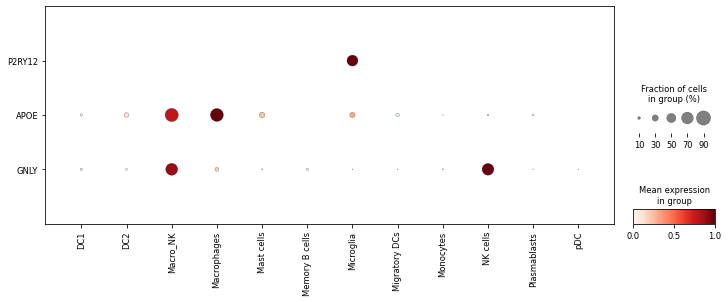

In [8]:
sc.pl.dotplot(adata_600, ['P2RY12', 'APOE', 'GNLY'], groupby = 'cell_type', swap_axes = True, standard_scale = 'var', figsize = [12, 4])

## Inspect the CellTypist built-in models

Download the latest CellTypist models.

In [9]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 34
📂 Storing models in /home/jovyan/.celltypist/data/models
💾 Downloading model [1/34]: Immune_Blood_Low.pkl
💾 Downloading model [2/34]: Immune_Upperairway_Low.pkl
💾 Downloading model [3/34]: Immune_Kidney_Low.pkl
💾 Downloading model [4/34]: Immune_All_Low.pkl
💾 Downloading model [5/34]: Immune_Upperairway_High.pkl
💾 Downloading model [6/34]: Immune_Mesentericlymphnode_High.pkl
💾 Downloading model [7/34]: Immune_Intestine_Low.pkl
💾 Downloading model [8/34]: Immune_Oesophagus_High.pkl
💾 Downloading model [9/34]: Immune_Colon_Low.pkl
💾 Downloading model [10/34]: Immune_Liver_Low.pkl
💾 Downloading model [11/34]: Immune_Thymus_Low.pkl
💾 Downloading model [12/34]: Immune_Lung_Low.pkl
💾 Downloading model [13/34]: Immune_Trachea_Low.pkl
💾 Downloading model [14/34]: Immune_Colon_High.pkl
💾 Downloading model [15/34]: Immune_Thymus_High.pkl
💾 Downloading model [16/34]: Immune_Spleen

All models are stored in `models.models_path`.

In [10]:
models.models_path

'/home/jovyan/.celltypist/data/models'

Get an overview of the models and what they represent.

In [11]:
models.models_description()

,model,description
0,Immune_Colon_Low.pkl,immune sub-populations from the colon
1,Immune_Liver_Low.pkl,immune sub-populations from the liver
2,Immune_All_Low.pkl,immune sub-populations combined from different...
3,Immune_Omentumadiposetissue_Low.pkl,immune sub-populations from the omentum adipos...
4,Immune_Mesentericlymphnode_Low.pkl,immune sub-populations from the mesenteric lym...
5,Immune_Blood_Low.pkl,immune sub-populations from the blood
6,Immune_Mesentericlymphnode_High.pkl,immune populations from the mesenteric lymph node
7,Immune_Oesophagus_High.pkl,immune populations from the oesophagus
8,Immune_Trachea_High.pkl,immune populations from the trachea
9,Immune_Kidney_High.pkl,immune populations from the kidney


Choose the model you want to employ, for example, the model with all tissues combined containing low-hierarchy (high-resolution) cell types/subtypes.

In [12]:
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')

This model contains 87 cell states.

In [13]:
model.cell_types

array(['B cells', 'CD8a/a', 'CD8a/b(entry)', 'CMP', 'Cycling B cells',
       'Cycling DCs', 'Cycling NK cells', 'Cycling T cells',
       'Cycling gamma-delta T cells', 'Cycling monocytes',
       'Cytotoxic T cells', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Fibroblasts', 'Follicular B cells', 'Follicular helper T cells',
       'GMP', 'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Helper T cells', 'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1',
       'ILC2', 'ILC3', 'Immature B cells', 'Kidney-resident macrophages',
       'Kupffer cells', 'Late erythroid', 'MAIT cells', 'MEMP', 'MNP',
       'Macrophages', 'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocyte-erythroid-mast cell progenitor',
       'Megakaryocytes/platelets', 'Memory B ce

Some model meta-information.

In [14]:
model.description

{'date': '2021-08-03 20:23:54.902884',
 'details': 'immune sub-populations combined from different organs/tissues',
 'url': 'https://celltypist.cog.sanger.ac.uk/models/v6/Immune_All_Low.pkl',
 'number_celltypes': 87}

## Single-label classification by finding the best match in the model
In this section, we show the procedure of finding the most likely cell type labels from built-in models for the query dataset.

We use the default mode (`mode = 'best match'`) to transfer cell type labels from the model to the query dataset. With this mode on, each query cell is predicted into the cell type with the largest score/probability among all possible cell types in the model.

In [15]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata_600, model = model, majority_voting = True, mode = 'best match')
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_600, model = 'Immune_All_Low.pkl', majority_voting = True, mode = 'best match')

🔬 Input data has 600 cells and 29568 genes
🔗 Matching reference genes in the model
🧬 7216 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [16]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
cell1,Plasmablasts,6,Plasmablasts
cell2,Plasmablasts,9,Plasmablasts
cell3,Plasmablasts,6,Plasmablasts
cell4,Plasmablasts,9,Plasmablasts
cell5,Plasmablasts,22,Memory B cells
...,...,...,...
cell596,Macrophages,13,Macrophages
cell597,Macrophages,8,Macrophages
cell598,Macrophages,4,Macrophages
cell599,Macrophages,8,Macrophages


Transform the prediction result into an `AnnData`.

In [17]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

Compared to `adata_600`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, and `majority_voting`).

In [18]:
adata.obs

,cell_type,predicted_labels,over_clustering,majority_voting
cell1,Plasmablasts,Plasmablasts,6,Plasmablasts
cell2,Plasmablasts,Plasmablasts,9,Plasmablasts
cell3,Plasmablasts,Plasmablasts,6,Plasmablasts
cell4,Plasmablasts,Plasmablasts,9,Plasmablasts
cell5,Plasmablasts,Plasmablasts,22,Memory B cells
...,...,...,...,...
cell596,Macro_NK,Macrophages,13,Macrophages
cell597,Macro_NK,Macrophages,8,Macrophages
cell598,Macro_NK,Macrophages,4,Macrophages
cell599,Macro_NK,Macrophages,8,Macrophages


In addition to this meta information added, the neighborhood graph constructed during over-clustering is also stored in the `adata` 
(If a pre-calculated neighborhood graph is already present in the `AnnData`, this graph construction step will be skipped).  
This graph can be used to derive the cell embeddings, such as the UMAP coordinates.

In [19]:
# If the UMAP or any cell embeddings are already available in the `AnnData`, skip this command.
sc.tl.umap(adata)

Visualise the prediction results.

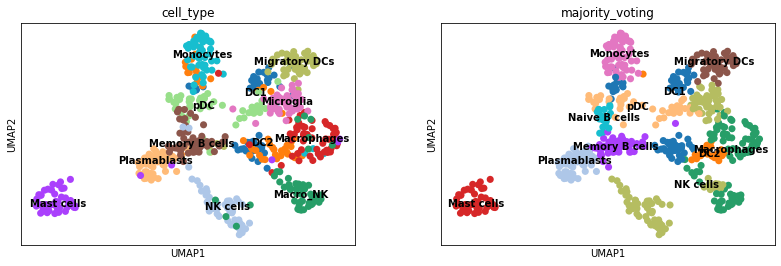

In [20]:
sc.pl.umap(adata, color = ['cell_type', 'majority_voting'], legend_loc = 'on data')

As the images show, with the default mode, `Microglia` is predicted as `NK cells`, and `Macro_NK` is predicted as a mixture of `Macrophages` and `NK cells`.

In [21]:
pd.crosstab(adata.obs.cell_type, adata.obs.majority_voting).loc[['Microglia','Macro_NK']]

majority_voting,DC1,DC2,Macrophages,Mast cells,Memory B cells,Migratory DCs,Monocytes,NK cells,Naive B cells,Plasmablasts,pDC
cell_type,,,,,,,,,,,
Microglia,0,0,1,0,1,1,0,41,0,0,6
Macro_NK,0,0,34,0,0,0,0,16,0,0,0


## Multi-label classification by utilising a probability threshold
In this section, we show the procedure of transferring multiple cell type labels from built-in models to the query dataset.

All cell types from the CellTypist models are trained in an one-vs-rest fashion, resulting in independent probability estimates that can be compared across cell types. Probabilities are transformed from the decision scores by the sigmoid function, and are kept as is without summing up to one for each query cell. Through this, a probability threshold (default to 0.5, `p_thres = 0.5`) can be used to determine the cell type(s) assigned to a given cell.

Turn on the multi-label classification by setting the `mode = 'prob match'` argument.

In [22]:
# `p_thres` defaults to 0.5.
predictions = celltypist.annotate(adata_600, model = 'Immune_All_Low.pkl', majority_voting = True, mode = 'prob match', p_thres = 0.5)

🔬 Input data has 600 cells and 29568 genes
🔗 Matching reference genes in the model
🧬 7216 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [23]:
adata = predictions.to_adata()

In [24]:
sc.tl.umap(adata)

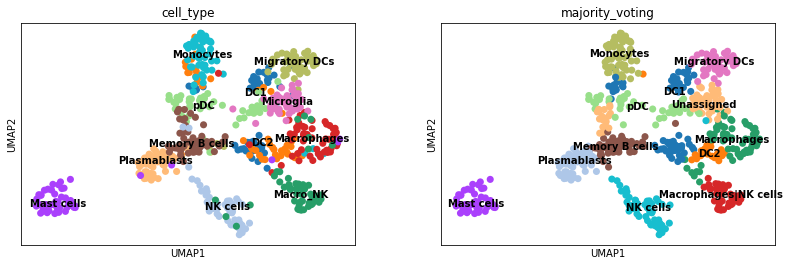

In [25]:
sc.pl.umap(adata, color = ['cell_type', 'majority_voting'], legend_loc = 'on data')

With the mode of probabilistic match, `Microglia` is predicted as `Unassigned`, and `Macro_NK` is predicted as `Macrophages|NK cells` (which follows the naming scheme of `celltype1|celltyp2`)

The probability estimates can be inserted into the adata as well by setting `insert_prob = True` in the `to_adata` function. After the insertion, multiple columns will show up in the cell metadata, with each column's name being a cell type name representing probabilities of this cell type distributed across the query cells.

In [26]:
adata = predictions.to_adata(insert_prob = True)
adata.obs[['cell_type', 'Plasmablasts']]

,cell_type,Plasmablasts
cell1,Plasmablasts,9.978965e-01
cell2,Plasmablasts,9.986958e-01
cell3,Plasmablasts,9.655770e-01
cell4,Plasmablasts,9.941201e-01
cell5,Plasmablasts,3.276947e-01
...,...,...
cell596,Macro_NK,9.300064e-06
cell597,Macro_NK,1.527888e-03
cell598,Macro_NK,9.996473e-06
cell599,Macro_NK,1.573979e-04


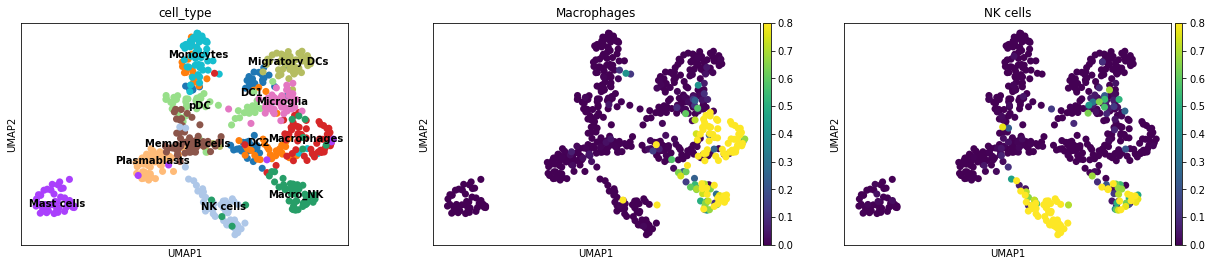

In [27]:
sc.pl.umap(adata, color = ['cell_type', 'Macrophages', 'NK cells'], vmin = 0, vmax = 0.8, legend_loc = 'on data')

Examination of probability distributions of `Macrophages` and `NK cells` shows the co-existence of their signatures in the doublet cluster `Macro_NK`, as well as noticeable `Macrophages` and `NK cells` scores in the `Microglia` cluster. Thus even CellTypist assigns the `Microglia` as `Unassigned`, the probability scores still indicate their possible transcriptomic similarity with `Macrophages` and `NK cells`.

## Multi-label classification using a custom model
In this section, we show the procedure of generating a custom model and transferring multiple labels from the model to the query data.

Download a dataset of 2,000 immune cells as the training set.

In [28]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')

  0%|          | 0.00/29.4M [00:00<?, ?B/s]

Use previously downloaded scRNA-seq dataset of 600 immune cells as a query.

In [29]:
adata_600 = sc.read('celltypist_demo_folder/demo_600_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_600_cells.h5ad')

Derive a custom model by training the data using the `celltypist.train` function.

In [30]:
# The `cell_type` in `adata_2000.obs` will be used as cell type labels for training.
new_model = celltypist.train(adata_2000, labels = 'cell_type')

🍳 Preparing data before training
✂️ 2151 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


By default, data is trained using a traditional logistic regression classifier. This classifier is well suited to datasets of small or intermediate sizes (as an empirical estimate, <= 100k cells), and usually leads to an unbiased probability range with less parameter tuning for multi-label classification. Among the training parameters, three important ones are `solver` which (if not specified by the user) is selected based on the size of the input data by CellTypist, `C` which sets the inverse of L2 regularisation strength, and `max_iter` which controls the maximum number of iterations before reaching the minimum of the cost function. Other (hyper)parameters from [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) are also applicable in the `train` function.

When the dimensions of the input data are large, training may take longer time even with CPU parallelisation (achieved by the `n_jobs` argument). To reduce the training time as well as to add some randomness to the classifier's solution, a stochastic gradient descent (SGD) logistic regression classifier can be enabled by `use_SGD = True`.

In [31]:
# For illustration purpose; below is not run for this small training data.
#new_model = celltypist.train(adata_2000, labels = 'cell_type', use_SGD = True)

A logistic regression classifier with SGD learning reduces the training burden dramatically and has a comparable performance versus a traditional logistic regression classifier. A minor caveat is that more careful model parameter tuning may be needed if you want to utilise the probability values from the model for multi-label classification. Among the training parameters, two important ones are `alpha` which sets the L2 regularisation strength and `max_iter` which controls the maximum number of iterations. Other (hyper)parameters from [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) are also applicable in the `train` function.

When the training data contains a huge number of cells (for example >500k cells) or more randomness in selecting cells for training is needed, you may consider using the mini-batch version of the SGD logistic regression classifier by specifying `use_SGD = True` and `mini_batch = True`. As a result, in each epoch (default to 10 epochs, `epochs = 10`), cells are binned into equal-sized (the size is default to 1000, `batch_size = 1000`) random batches, and are trained in a batch-by-batch manner (default to 100 batches, `batch_number = 100`).

In [32]:
# For illustration purpose; below is not run for this small training data.
#new_model = celltypist.train(adata_2000, labels = 'cell_type', use_SGD = True, mini_batch = True)

In general, for a single-label classification problem, all the three training approaches yield comparable prediction accuracies. For a multi-label classification problem, traditional logistic regression classifier requires less parameter tuning but needs longer training time, opposite to the two SGD-based logistic regression classifiers. 

This custom model can be manipulated as with other CellTypist built-in models. First, save this model locally.

In [33]:
# Save the model.
new_model.write('celltypist_demo_folder/model_from_immune2000.pkl')

You can load this model by `models.Model.load`.

In [34]:
new_model = models.Model.load('celltypist_demo_folder/model_from_immune2000.pkl')

Next, we use this model to predict the query dataset of 600 immune cells.

In [35]:
# Not run; predict the identity of each input cell with the new model.
#predictions = celltypist.annotate(adata_600, model = new_model, majority_voting = True, mode = 'prob match', p_thres = 0.5)
# Alternatively, just specify the model path (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_600, model = 'celltypist_demo_folder/model_from_immune2000.pkl', majority_voting = True, mode = 'prob match', p_thres = 0.5)

🔬 Input data has 600 cells and 29568 genes
🔗 Matching reference genes in the model
🧬 16799 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [36]:
adata = predictions.to_adata(insert_prob = True)

In [37]:
sc.tl.umap(adata)

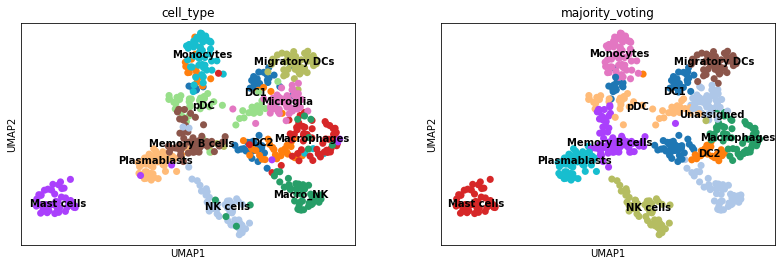

In [38]:
sc.pl.umap(adata, color = ['cell_type', 'majority_voting'], legend_loc = 'on data')

As well as `Microglia`, `Macro_NK` is also predicted as `Unassigned`, which is assigned as `Macrophages|NK cells` using the built-in CellTypist model. This is possibly due to the lack of power in this small training dataset to assign definitive labels.

<AxesSubplot:title={'center':'Macro_NK'}>

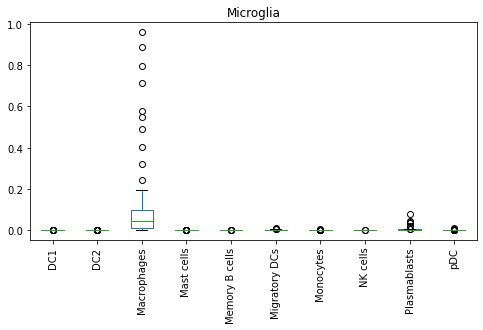

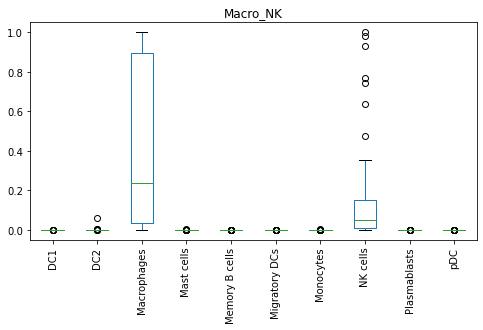

In [39]:
adata.obs.loc[adata.obs.cell_type == 'Microglia', new_model.cell_types].plot(kind = 'box', rot = 90, figsize = [8, 4], title = 'Microglia')
adata.obs.loc[adata.obs.cell_type == 'Macro_NK', new_model.cell_types].plot(kind = 'box', rot = 90, figsize = [8, 4], title = 'Macro_NK')

Based on this model, `Microglia`, though designated as `Unassigned` by CellTypist, holds relatively higher probability scores with `Macrophages`. `Macro_NK`, on the other hand, holds relatively higher probability scores with both `Macrophages` and `NK cells`.

## Examine expression of cell type-driving genes

Each model can be examined in terms of the driving genes for each cell type. Note these genes are only dependent on the model, say, the training dataset.

In [40]:
# Any model can be inspected.
# Here we load the previously saved model trained from 2,000 immune cells.
model = models.Model.load(model = 'celltypist_demo_folder/model_from_immune2000.pkl')

In [41]:
model.cell_types

array(['DC1', 'DC2', 'Macrophages', 'Mast cells', 'Memory B cells',
       'Migratory DCs', 'Monocytes', 'NK cells', 'Plasmablasts', 'pDC'],
      dtype=object)

Extract the matrix of gene weights across cell types.

In [42]:
weights = model.classifier.coef_
weights.shape

(10, 16799)

Top three driving genes of `Macrophages`.

In [43]:
macro_cell_weights = weights[model.cell_types == 'Macrophages']
top_3_genes = model.features[macro_cell_weights.argpartition(-3, axis = None)[-3:]]
top_3_genes

array(['GPNMB', 'APOC1', 'APOE'], dtype=object)

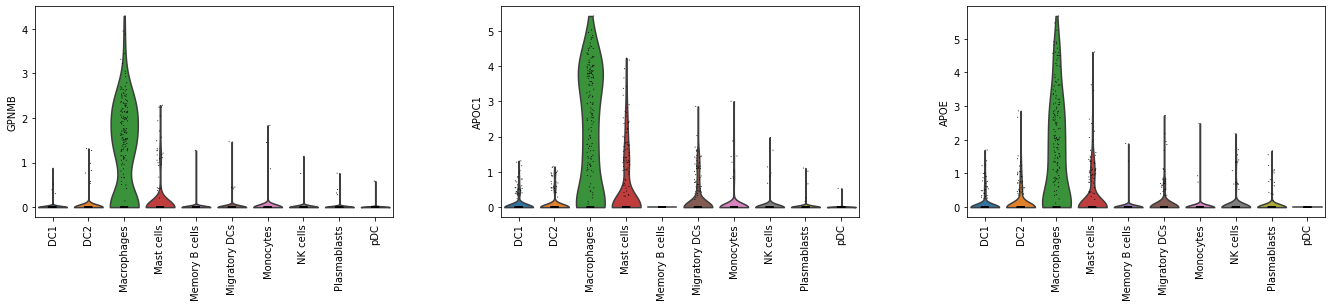

In [44]:
# Check expression of the three genes in the training set.
sc.pl.violin(adata_2000, top_3_genes, groupby = 'cell_type', rotation = 90)

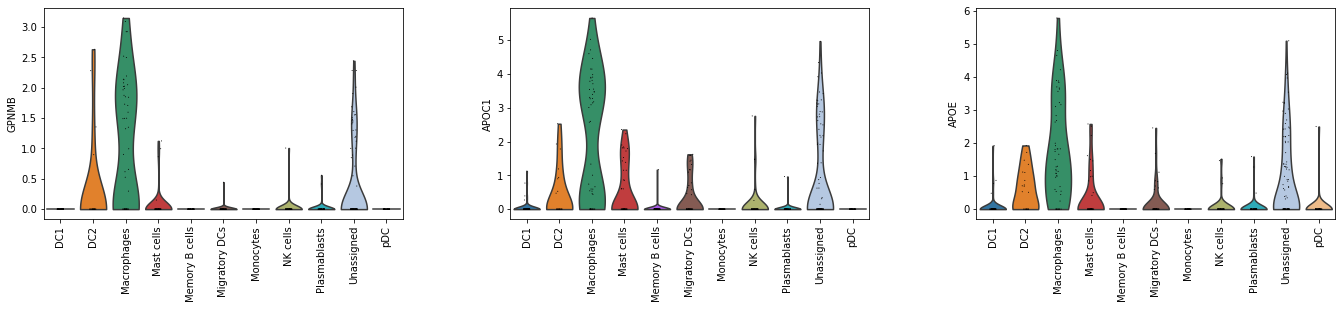

In [45]:
# Check expression of the three genes in the query set.
# Here we use `majority_voting` from CellTypist as the cell type labels for this dataset.
sc.pl.violin(adata_600, top_3_genes, groupby = 'majority_voting', rotation = 90)